In [ ]:
# hide
# all_slow

# Classification ResNets in FastAI

> Multilabel classification for the first step in the inference pipeline.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/nbs/_10_fastai.classifier.ipynb)

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from steel_segmentation.all import *

from fastcore.foundation import *
from fastai.vision.all import *
import fastai
import albumentations as alb

In [ ]:
fastai.__version__

'2.3.0'

In [ ]:
torch.__version__

'1.7.1+cu101'

In [ ]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [ ]:
!nvidia-smi

Sat Apr 10 10:29:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   27C    P8    11W / 120W |      4MiB /  8126MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class_metrics = [accuracy_multi, PrecisionMulti(), RecallMulti(), F1ScoreMulti()]

In [ ]:
seed_everything()

## Training ResNet18 encoder

Training a `resnet18` encoder for segmentation `Unet` or `FPN`.

In [ ]:
bs = 32
size = (256, 1568)

In [ ]:
arch = partial(resnet18, pretrained=True)

Different augmentations for the training and validation phase:

In [ ]:
class AlbumentationsTransformClassifier(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [ ]:
def get_train_aug(height, width): 
    first_step = alb.RandomCrop(height, width, p=1.)
    
    second_step = alb.OneOf([alb.VerticalFlip(p=0.5),
                              alb.HorizontalFlip(p=0.5)
                             ], p=0.8)
    
    third_step = alb.OneOf([
        alb.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), 
                                     contrast_limit=(-0.2, 0.2), 
                                     brightness_by_max=True,
                                     p=0.5),
        alb.RandomGridShuffle(always_apply=False, p=0.5, grid=(2, 3))], p=0.8)
    
    # to do: try with grayscale imgs
    last_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step, second_step, third_step])

def get_valid_aug(height, width): 
    first_step = alb.RandomCrop(height, width)
    last_step = alb.ToGray(always_apply=False, p=1.0)
    return alb.Compose([first_step])

train_tfm = get_train_aug(*size)
valid_tfm = get_valid_aug(*size)
item_tfms = [AlbumentationsTransformClassifier(train_tfm, valid_tfm)]

In [ ]:
b_tfms = [Normalize.from_stats(*imagenet_stats)]

dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock()),
        get_x=ColReader(0, pref=train_path),
        get_y=ColReader(1, label_delim=' '),
        splitter=RandomSplitter(valid_pct=0.2),
        item_tfms=item_tfms,
        batch_tfms=b_tfms)

I select only defected images to train the multilabel classification model.

In [ ]:
df = train_multi.loc[train_multi["ImageId"].isin(train["ImageId"].tolist())]
df.shape

(6666, 2)

In [ ]:
#dblock.summary(df)

In [ ]:
dls = dblock.dataloaders(source=df, bs=bs)

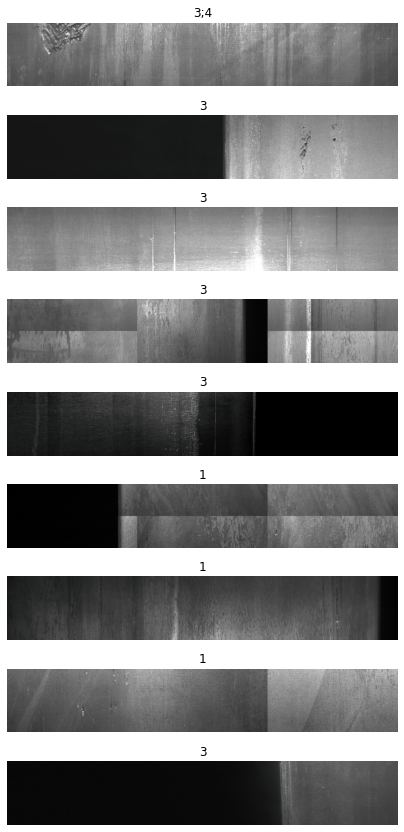

In [ ]:
dls.show_batch(ncols=1, figsize=(7,15))

In [ ]:
learner = cnn_learner(dls=dls, 
                      arch=arch, 
                      metrics=class_metrics, 
                      model_dir=models_dir,
                      pretrained=True,
                      cbs=[ShowGraphCallback()]
                     ).to_fp16()

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.033113110810518265)

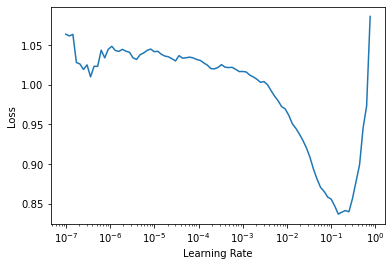

In [ ]:
learner.lr_find()

In [ ]:
cb_fit = [SaveModelCallback(fname="resnet18_class")]

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,0.563556,0.264489,0.911853,0.677753,0.773570,0.715871,02:52
1,0.253472,0.170448,0.927044,0.838986,0.696848,0.748360,02:52
2,0.220950,0.135441,0.948612,0.908861,0.763323,0.821161,02:52
3,0.183469,0.133654,0.946737,0.832035,0.845196,0.835317,02:52
4,0.166533,0.114277,0.954426,0.847104,0.875187,0.860663,02:52


Better model found at epoch 0 with valid_loss value: 0.26448869705200195.


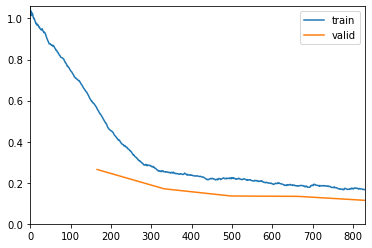

Better model found at epoch 1 with valid_loss value: 0.1704479157924652.
Better model found at epoch 2 with valid_loss value: 0.13544081151485443.
Better model found at epoch 3 with valid_loss value: 0.13365359604358673.
Better model found at epoch 4 with valid_loss value: 0.11427661031484604.


epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,0.134821,0.103742,0.958927,0.861757,0.892618,0.865828,04:04
1,0.125084,0.097122,0.960803,0.903715,0.849692,0.874766,04:04
2,0.108739,0.079742,0.969993,0.951255,0.860147,0.900966,04:04
3,0.099706,0.084041,0.967179,0.898693,0.895132,0.893815,04:04
4,0.085958,0.076017,0.968305,0.886458,0.930034,0.904783,04:04
5,0.076266,0.069936,0.972243,0.910846,0.920386,0.914313,04:04
6,0.065737,0.067895,0.974119,0.913037,0.925762,0.918481,04:04
7,0.055335,0.062298,0.976744,0.944256,0.916001,0.929858,04:04
8,0.049913,0.062469,0.975431,0.945402,0.930273,0.937756,04:04
9,0.044784,0.061812,0.976744,0.940877,0.925376,0.932942,04:04


Better model found at epoch 0 with valid_loss value: 0.1037418395280838.


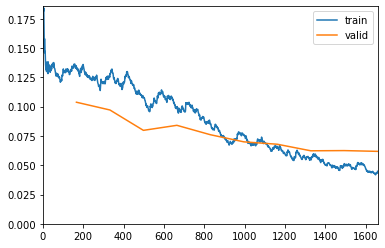

Better model found at epoch 1 with valid_loss value: 0.09712249785661697.
Better model found at epoch 2 with valid_loss value: 0.07974239438772202.
Better model found at epoch 4 with valid_loss value: 0.07601717859506607.
Better model found at epoch 5 with valid_loss value: 0.0699363425374031.
Better model found at epoch 6 with valid_loss value: 0.06789499521255493.
Better model found at epoch 7 with valid_loss value: 0.0622979961335659.
Better model found at epoch 9 with valid_loss value: 0.06181157007813454.


In [ ]:
learner.fine_tune(10, freeze_epochs=5, base_lr=1e-02, cbs=cb_fit)

In [ ]:
model = learner.model[0]
saving_path = models_dir / "ResNet18-encoder.pt"
torch.save(model.state_dict(), saving_path)